# Segmentación semántica


La segmentación semántica es una técnica que consiste en clasificar cada pixel de una imágen en una categoría o clase predefinida. Por ejemplo, en una imágen con personas y autos, la segmentación semántica etiquetará los pixeles que pertenecen unicamente a personas, y usará otra etiqueta para los pixeles que pertenecen a la clase carros.

La segmentación semántica es útil para diferenciar distintas clases de objetos pero no separa las instancias. Siguiendo el ejemplo anterior, se pueden distinguir las personas pero no se hace la separación de cada persona. El proceso de segmentación semántica se logra generalmente con `modelos de aprendizaje profundo`, especialmente con redes neurales convolucionales `CNNs`.

El resultado de la segmentación semántica es una máscara de segmentación donde cada clase de objeto tiene un color asociado.

## Segmentación semántica de autos con DeepLabv3 Resnet101

`deeplabv3_resnet101` es un modelo pre-entrenado de PyTorch. El modelo esta entrenado con un subconjunto del dataset `COCO` y hace uso de 20 de las categorías que se encuentran presente en el dataset de `Pascal VOC`.

Este modelo utiliza la `convolución atrous`.

In [ ]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

def load_model():
    model = models.segmentation.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)
    model.eval()
    return model

def semantic_segmentation(model, img_path):
    # Load image
    img_original = Image.open(img_path).convert('RGB')# Convert to RGB to avoid 4 channel problems
    img_original_arr = np.array(img_original)

    # Configure the model
    preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    input_batch = preprocess(img_original).unsqueeze(0)

    # Use cuda if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out']

    # Convert to probabilities (value between 0 and 1) for cars
    car_index = 7
    car_prob = output[0][car_index].sigmoid()

    # Select pixels where probability of being a car is > 0.9
    mask_1d = (car_prob > 0.9).cpu().numpy().astype(np.uint8)

    # Turn 1d array into a 3d array
    mask_2d = mask_1d.reshape(mask_1d.shape)
    mask_3d = np.zeros((mask_1d.shape[0],mask_1d.shape[1], 3), dtype=np.uint8)
    mask_3d[mask_2d == 1, 1] = 255  # Set green channel for car pixels

    # Add mask to the original image
    mask_nonzero = np.any(mask_3d != [0, 0, 0], axis=-1)  # shape: (H, W)
    img_result = img_original_arr.copy()
    img_result[mask_nonzero] = mask_3d[mask_nonzero]
    return (img_original, img_result)

def show_images(img, img_result):
    # Print images side by side
    plt.figure(figsize=(20, 5), num='Semantic Segmentation')
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Car Segmentation")
    plt.imshow(img_result)
    plt.axis('off')

    plt.show()

model = load_model()


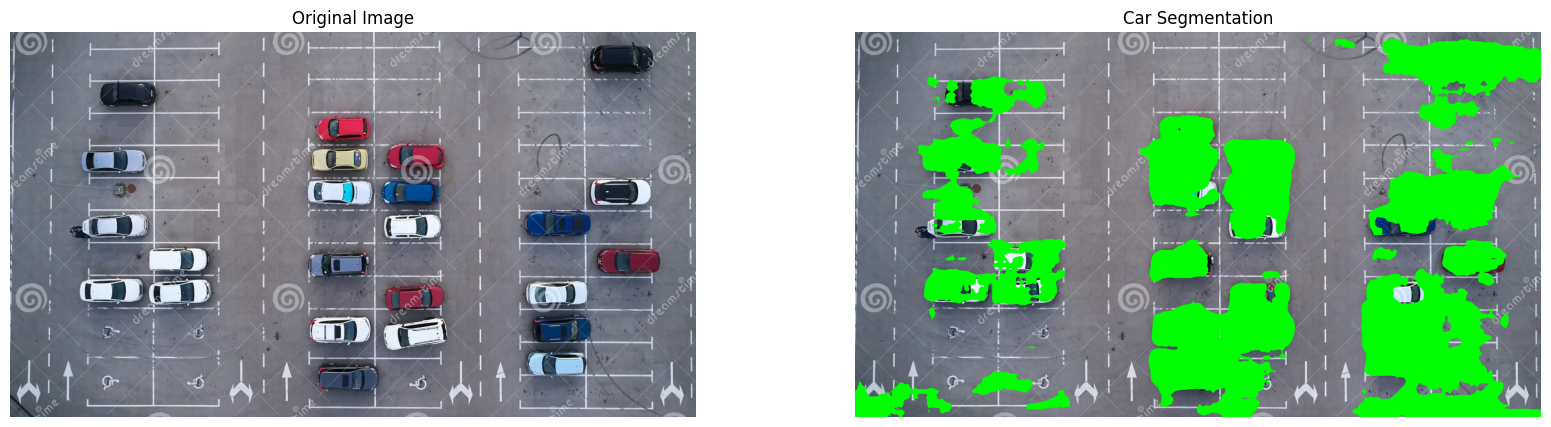

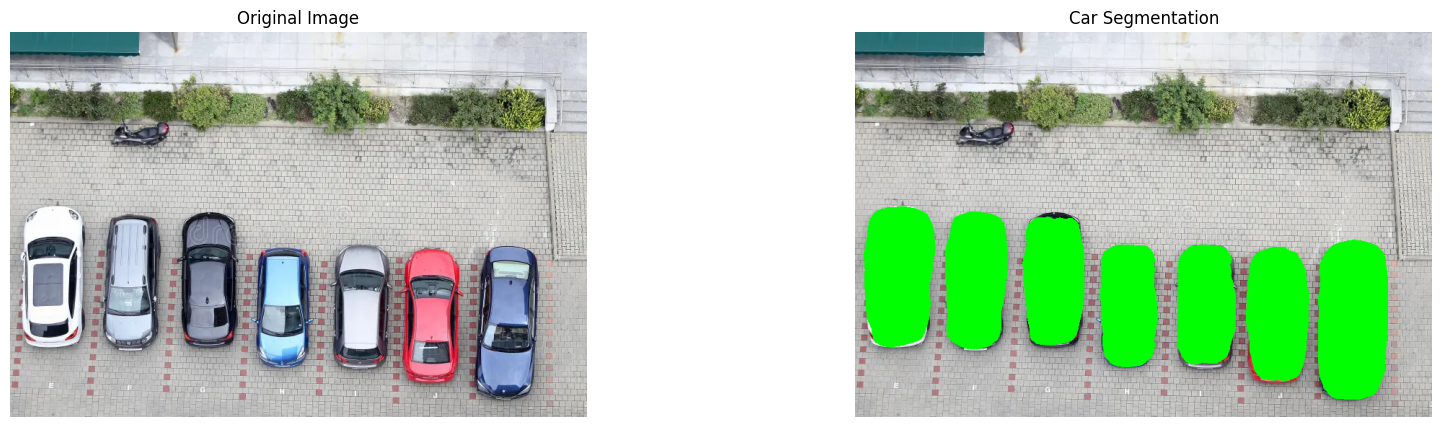

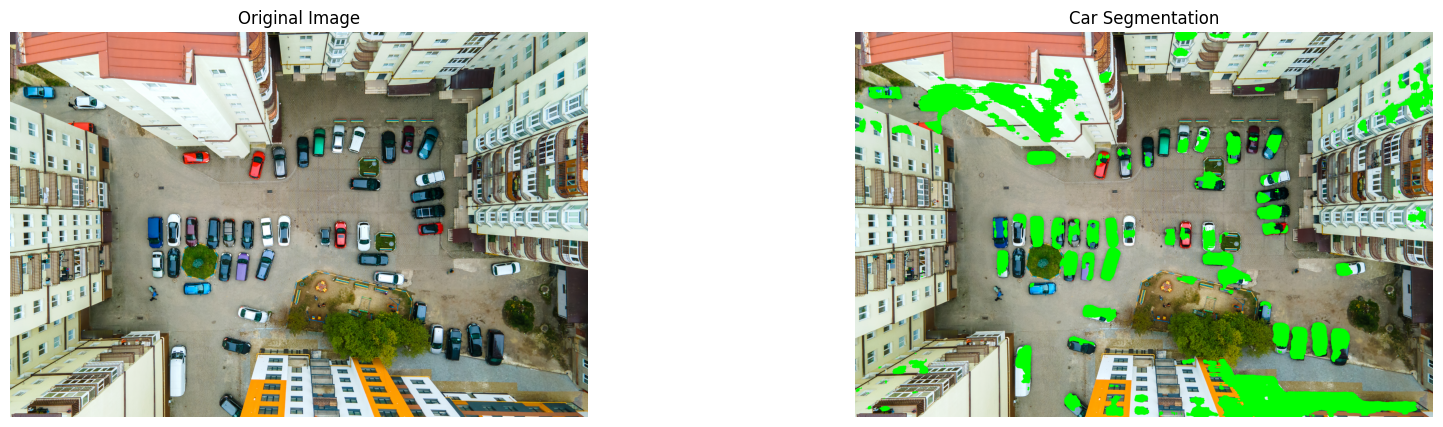

In [8]:
img1, img_result1 = semantic_segmentation(model, './cars_startup/car1.png')
img2, img_result2 = semantic_segmentation(model, './cars_startup/car2.png')
img3, img_result3 = semantic_segmentation(model, './cars_startup/car3.jpg')
show_images(img1, img_result1)
show_images(img2, img_result2)
show_images(img3, img_result3)